# Desafio

A empresa Você Mais Seguro fornece planos de saúde e seguros de vida. 
A empresa está interessada em lança um novo seguro de veiculos, e desja entender a propensão de compra de seus clientes para este novo cenário. 
Em uma primeira etapa, foi realizada uma grande pesquisa com seus cleintes, para entender quais destes clientes estariam interessados em adquirir o novo seguro de veiculos.

Agora, com novos clientes do plano de saude entrando para sua base, a empresa deseja entender quais destes novos clientes teriam maior propensão de compra do novo seguro de veiculos.
No entanto, a empresa não esta interessada em gastar com pesquisas para todos os novos clientes, e sim apenas para aqueles que tem maior propensão de compra, 
haja visto,que seu efetivo comercial, não é capaz de entrar em contato, para fornecer um processo de pré vendas personalizado para toda a base de seus novos clientes, somente
para 2000 deles de cada vez. 

Para isso, este projeto tem como objetivo apresentar uma lista, com os 2000 clientes com maior probabilidade de venda do seguro de veículos.

# 0.0 Imports

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


### 0.1 Helper Functions

In [56]:
def print_descriptive_stats(df,
                            column):
    print(f'**Clientes que adquiririam o Seguro - {column} statistics**')
    print(df[df.Response == 1][column].describe())
    print('-'*45)
    print(f'**Clientes NAO que adquiririam o Seguro - {column} statistics**')
    print(df[df.Response == 0][column].describe())
    print('\n')

def get_frequency_table(df, column): 

    df_frequency_1 = df[df.Response == 1].groupby(column).Response.count().reset_index()
    df_frequency_1.rename(columns={'Response':'Count_Response_1'}, inplace=True)


    df_frequency_0 = df[df.Response == 0].groupby(column).Response.count().reset_index()
    df_frequency_0.rename(columns={'Response':'Count_Response_0'}, inplace=True)

    df_frequency = pd.merge(df_frequency_1, df_frequency_0, on=column, how='inner') 
    df_frequency['Total'] = df_frequency['Count_Response_1'] + df_frequency['Count_Response_0']
    df_frequency['Propensity_to_buy'] = df_frequency['Count_Response_1']/df_frequency['Total']
    df_frequency['%_sample_to_buy'] = df_frequency['Count_Response_1']/df_frequency['Count_Response_1'].sum() 
    df_frequency['%_sample_to_not_buy'] = df_frequency['Count_Response_0']/df_frequency['Count_Response_0'].sum() 
    df_frequency['%_sample_size']   = df_frequency['Total']/len(df)
    
    return df_frequency

# 1.0 Limpeza dos Dados

**Tipos de limpezas**

* Nulos
* Tipagem inconsistente 
* Claros outliers (indicio de erro de digitação)


### 1.1 - Conhecendo o Dataset

In [2]:
df_raw = pd.read_csv('../data/raw/data.csv')
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


**Features e NaN** 

In [ ]:
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Não há NaN no dataset

----

**Descrevendo algumas features**

---- 

**Vintage:** - Tempo em dias, que o cliente esta na base da empresa.

**Policy Sales Channel** - Canal de contato com o cliente

**Vehicle_Damage:** - O Cliente ja teve algum dano em seu veiculo? 

**Previously Insured:** - O cliente já possuí algum seguro veicular?



### 1.2 - Validando os valores de cada coluna

Aqui o objetivo é compreender o valor presente em cada coluna, e se halguma coluna, não possuí algum valor de tipo inconsistente: 

**Exemplo:** idade possui valores do tipo string

In [4]:
cols_to_evaluate = df_raw.columns
cols_to_evaluate = cols_to_evaluate.drop(['id'])
cols_to_evaluate

for col in cols_to_evaluate:
    print('---'*20)
    print(col)
    print(df_raw[col].value_counts())

------------------------------------------------------------
Gender
Gender
Male      206089
Female    175020
Name: count, dtype: int64
------------------------------------------------------------
Age
Age
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: count, Length: 66, dtype: int64
------------------------------------------------------------
Driving_License
Driving_License
1    380297
0       812
Name: count, dtype: int64
------------------------------------------------------------
Region_Code
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0    

#### Conclusões

**Não foi identificada inconsistencia de tipagem**

Aqui não considerei a idade do veiculo (> 1 year...) como inconsistencia, uma vez que a ideia do campo, é realmente ser um campo do tipo texto.

### 1.3 - Identificando outliers claros que indicam falha no preenchimento dos dados

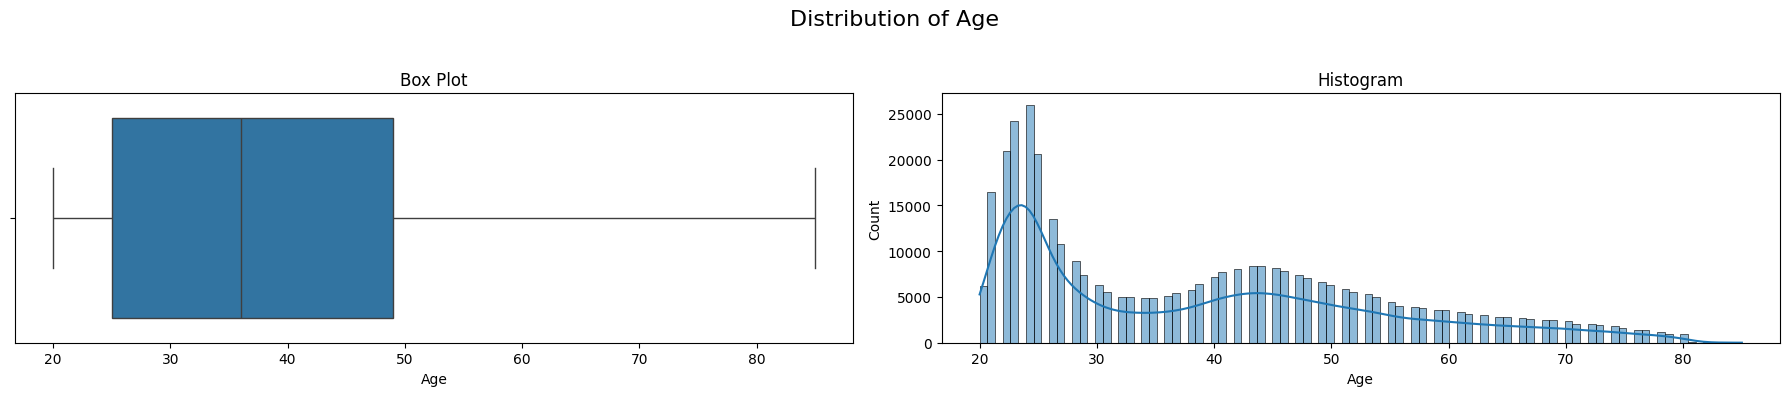

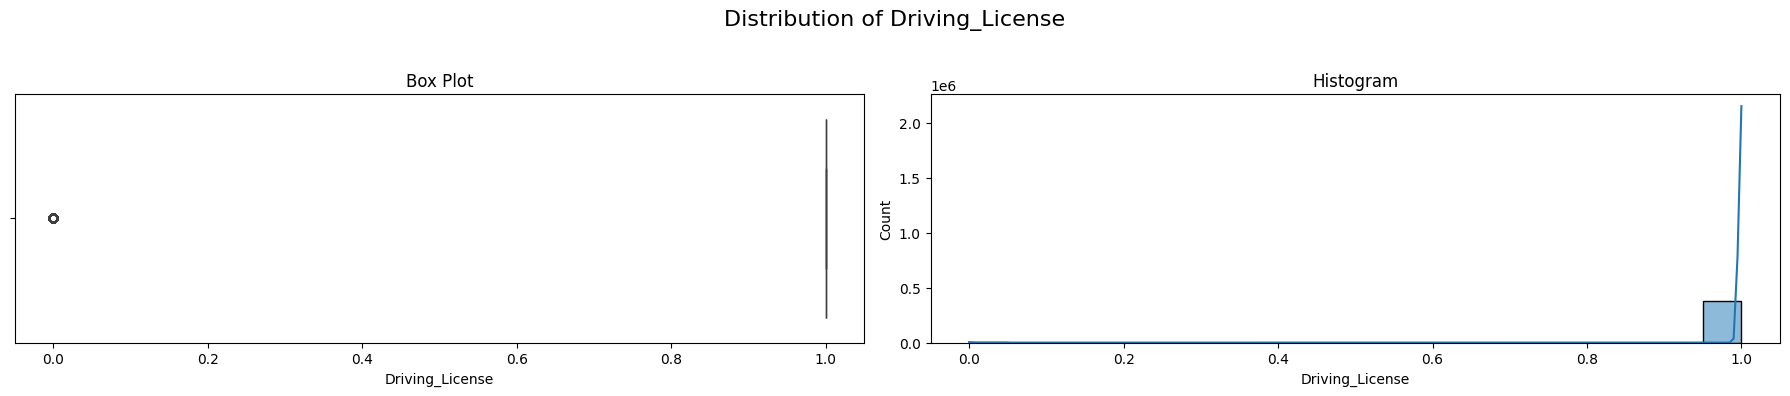

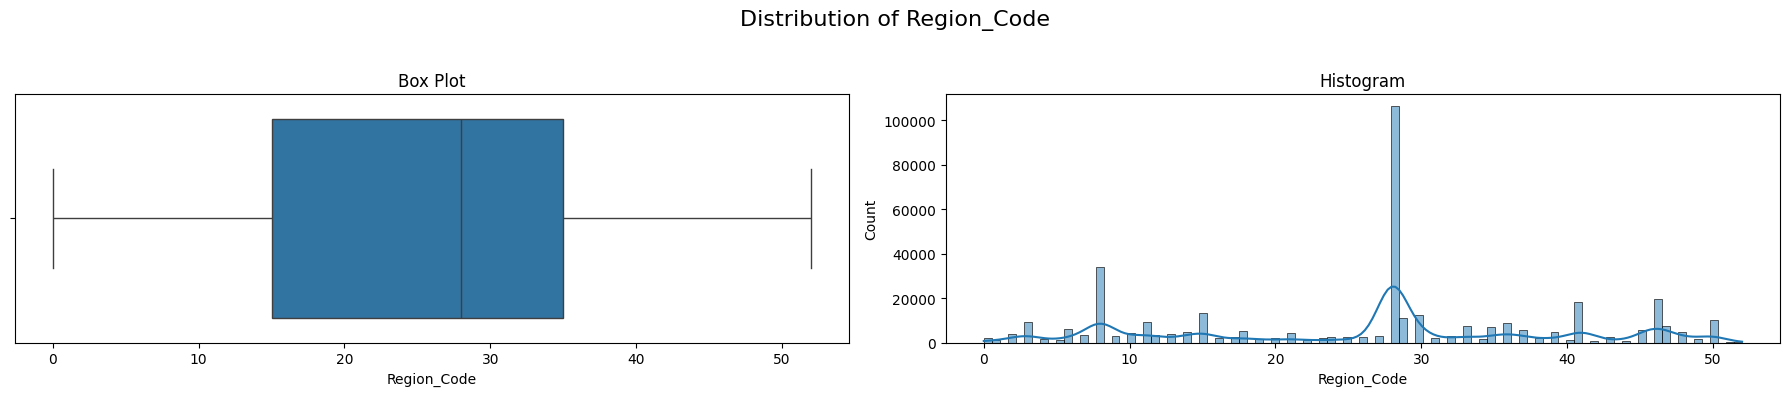

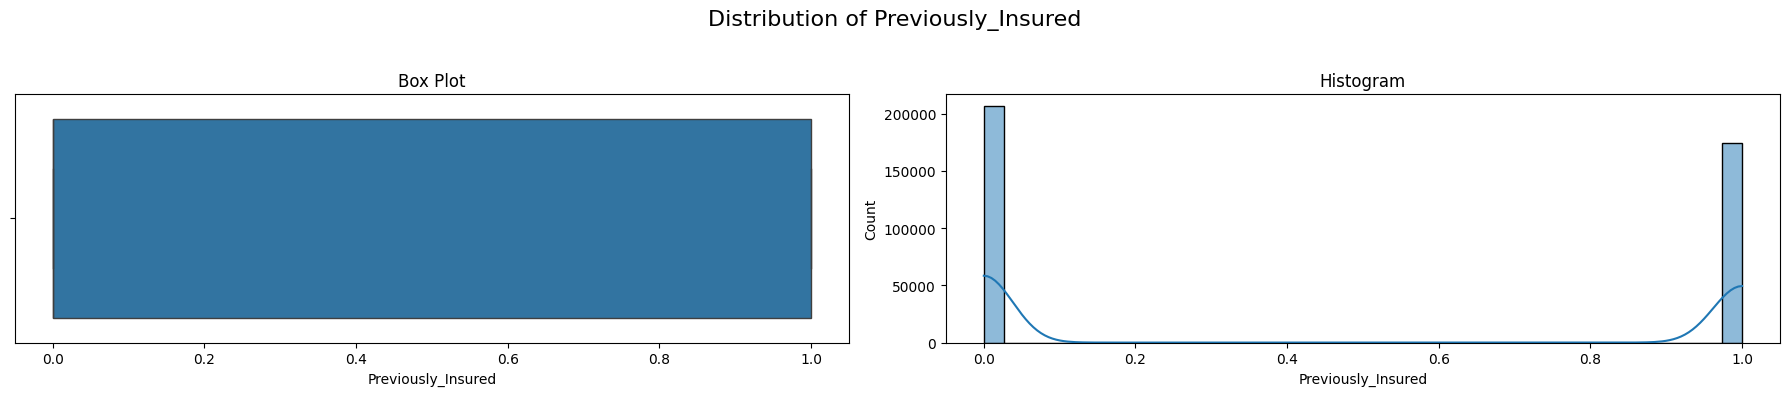

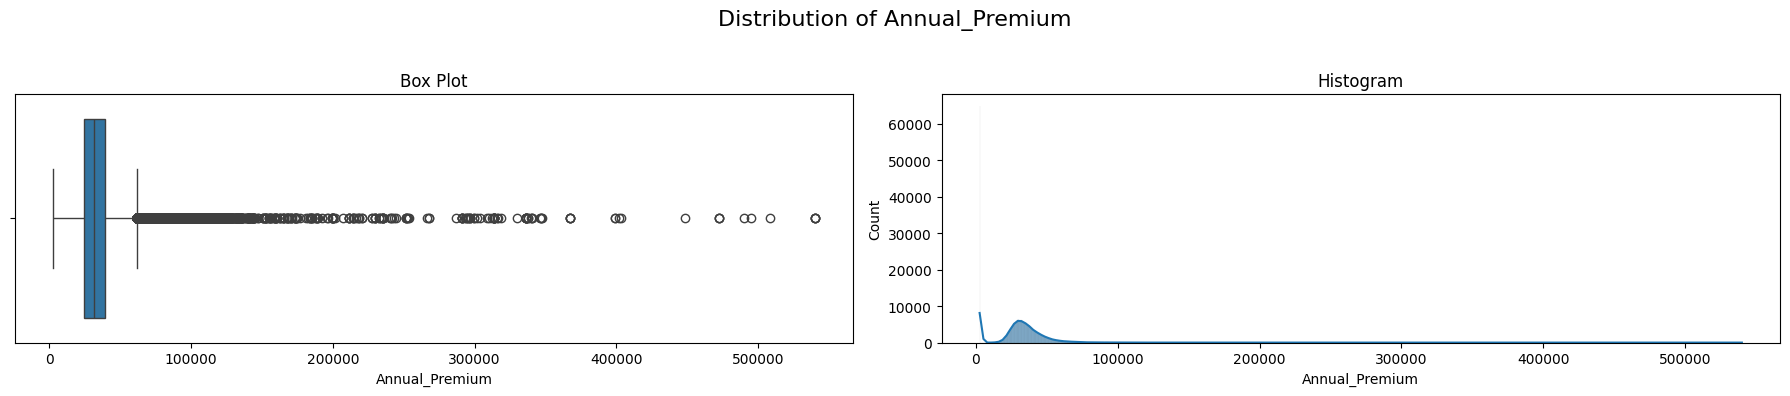

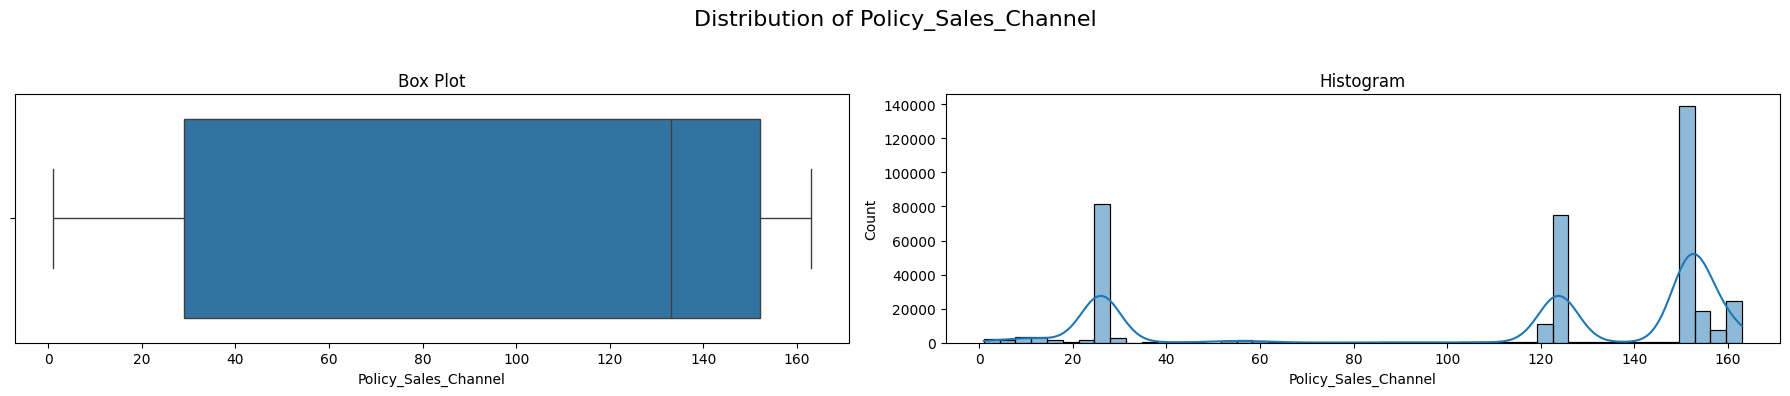

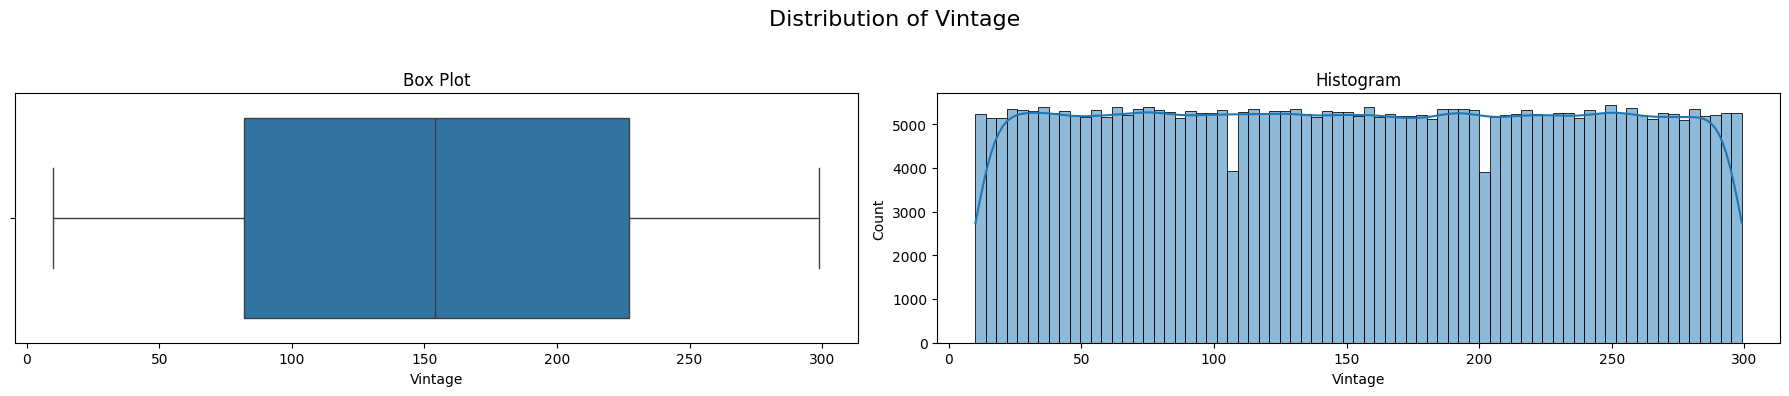

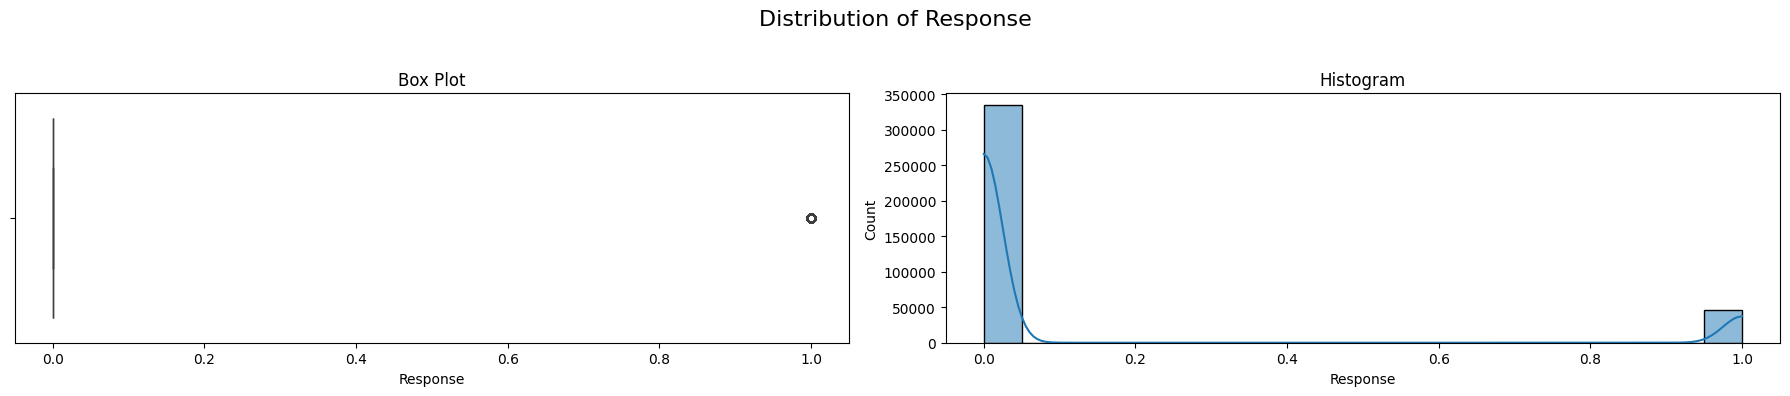

In [ ]:


# Your DataFrame and column list would be defined here
# Example: df_raw = pd.DataFrame(...)
# Example: cols_to_evaluate = ['col_name_1', 'col_name_2']

for col in cols_to_evaluate:
    if df_raw[col].dtype in ('int64', 'float64'):
        # 1. Define the figure size
        plt.figure(figsize=(18, 4))
        
        # 2. BOXPLOT: Position 1 of 2
        plt.subplot(1, 2, 1) # <--- Corrected this to be 1, 2, 1
        sns.boxplot(x=df_raw[col])
        plt.title('Box Plot') # Optional: Add a title to the subplot
        
        # 3. HISTOGRAM: Position 2 of 2
        plt.subplot(1, 2, 2) # <--- Corrected this to be 1, 2, 2
        sns.histplot(x=df_raw[col], kde=True)
        plt.title('Histogram') # Optional: Add a title to the subplot
        
        # 4. Main title and display
        plt.suptitle(f'Distribution of {col}', fontsize=16) # Using f-string for clarity
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()

##### Conclusões

Apesar do campo Annual Premium, possuir claros outliers, isso não indica uma falha real no preenchimento dos dados, apenas expõe que existem clientes com valores de premio absurdamente maiores que outros (algo totalmente coerente/possível de ocorrer em uma seguradora de saúde)

# 2.0 Exploração dos dados

## 2.0.1 - Separação do dataset

Como possuímos uma boa quantidade de amostras, para evitar que a consutrução/modelagem do problema sofra algum vies inserido por algum conhecimento adquirido na análise exploratória, vamos separar o dataset em treino, teste e validação neste momento. Desta forma garantimos que não havera nenhum tipo de vazamento de dados 


In [29]:
df_train, df_test = train_test_split(df_raw, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

print(f'Train shape: {df_train.shape}'
      f'\nValidation shape: {df_val.shape}' 
      f'\nTest shape: {df_test.shape}')

df_1 = df_train.copy()
df_1.head()

Train shape: (243909, 12)
Validation shape: (60978, 12)
Test shape: (76222, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
217927,217928,Female,38,1,47.0,1,1-2 Year,No,32726.0,152.0,75,0
54207,54208,Male,21,1,46.0,1,< 1 Year,No,30429.0,160.0,123,0
18364,18365,Male,66,1,28.0,0,1-2 Year,Yes,54905.0,154.0,22,0
195540,195541,Female,41,1,28.0,1,1-2 Year,No,65737.0,26.0,260,0
30463,30464,Male,50,1,15.0,0,1-2 Year,Yes,39205.0,26.0,221,0


## 2.1 - Mapa de hipoteses

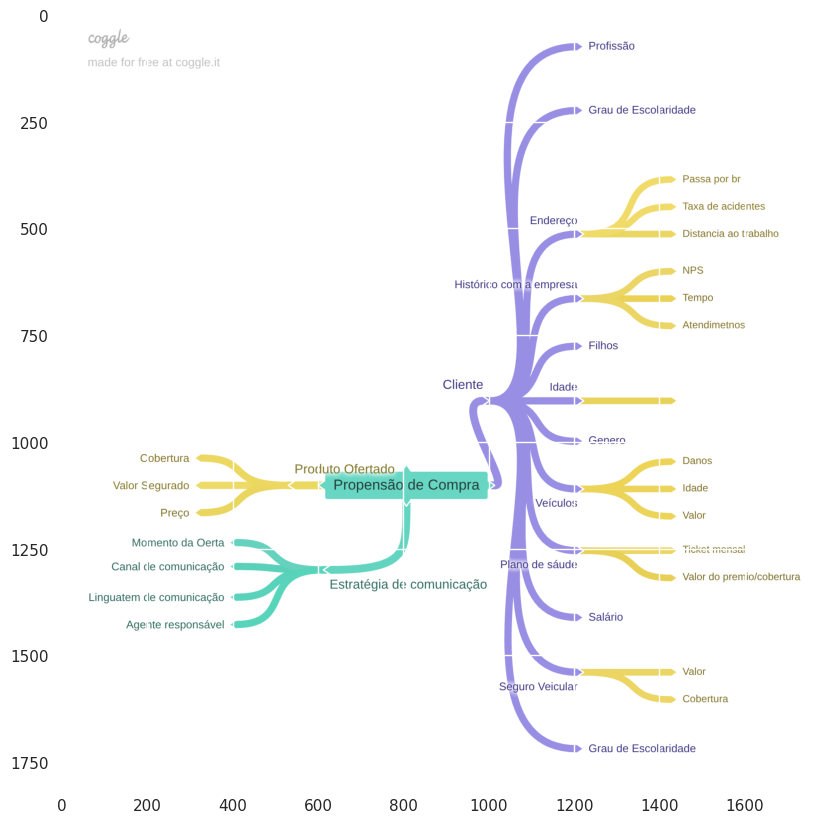

In [30]:
from matplotlib import pyplot as plt
import numpy as np 
from PIL import Image


img = Image.open('./media/propensao_de_compra_mind_map.png')
numpy = np.array(img)

plt.figure(figsize=(20, 10))
plt.imshow(numpy)

## 2.2 - Hipoteses:


**Cliente:**

1. ~~Clientes com maior grau de escolaridade possuem maior propensão de compra~~
2. ~~Clientes com Veiculos com preço mais elevado possuem maior propensão de compra~~
3. Clientes com mais tempo na base, possuem maior propensão de compra
4. Clientes com Ticket mais elevado possuem maior propensão de compra 
5. Clientes com Veiculos mais novos possuem maior propensão de compra 
6. Clientes com seguro veicular possuem menor propensão de compra 
7. Existem regiões, onde os clientes possuem maior propensão de compra
8. Clientes com veiculos que ja sofreram danos, possuem maior propensão a aquisição do seguro 
9. Clientes com mais de 30 anos, são mais propensos a adquirir o seguro.
10. ~~Clientes com Salario mais elevado, possuem maior propensão~~
11. Clientes do sexo feminino, possuem maior propensão a aquisição de seguros veiculares


**Estrategia de comunicação**

1. ~~Abordagems em canais de telefonia, elevam a propensão de compra do cliente.~~ 
2. ~~Ofertas realizadas a clientes no inicio do dia, elevam a propensão de compra~~
3. ~~O agente quiabo, eleva a propensão de compra~~

**Produto:**

1. ~~Seguros com maior relação (valor_cobertura/preço) possuem maior propensão de compra.~~ 

## 2.3 - Validando Hipoteses

### 2.3.1 - Clientes

#### H3 - Clientes com mais tempo na base possuem maior propensão de compra

**Falsa**

<Axes: xlabel='Vintage', ylabel='Response'>

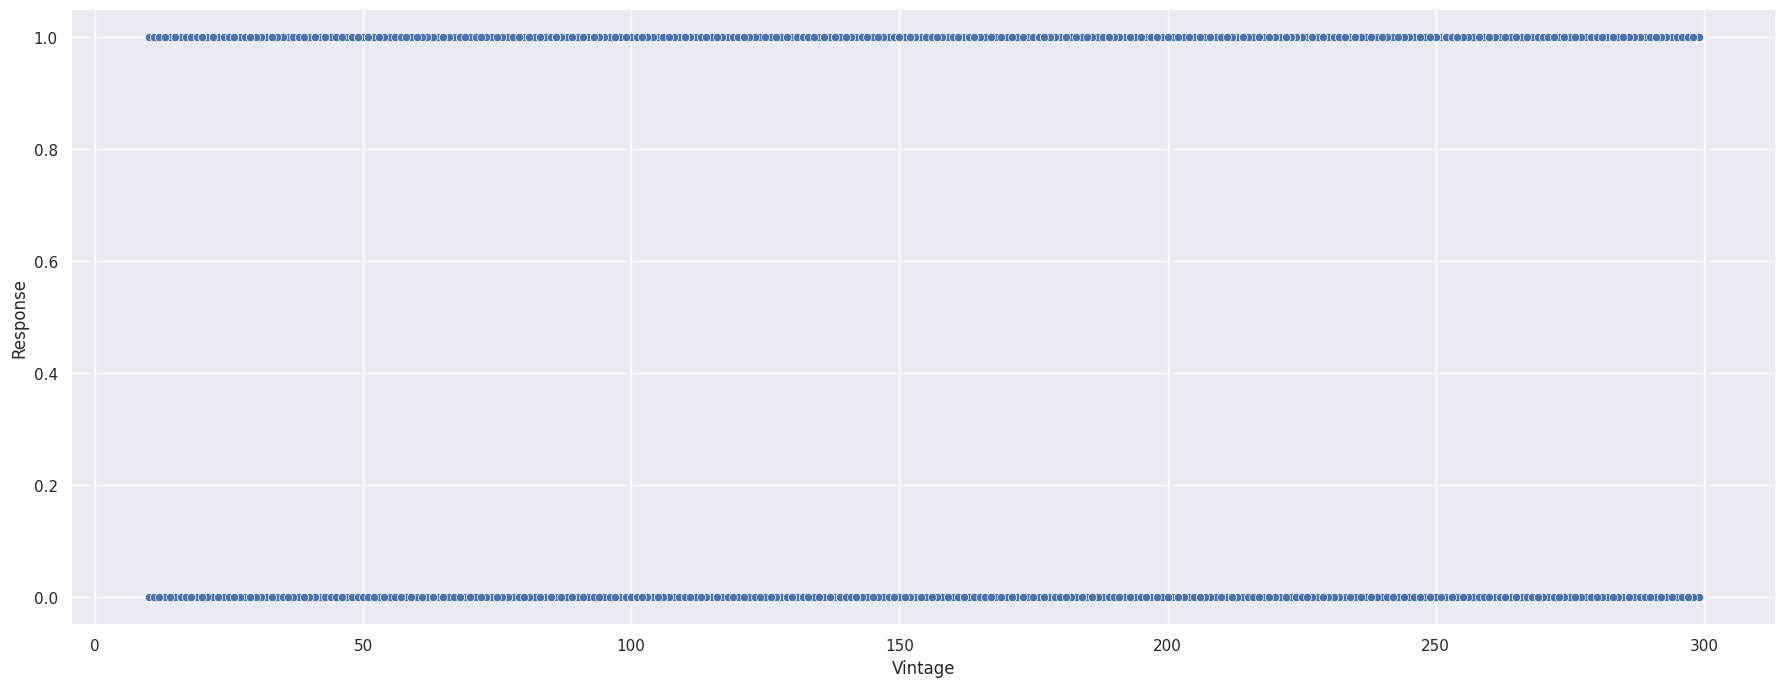

In [31]:
sns.scatterplot(data = df_1,x='Vintage', y='Response')

In [32]:
df_1[df_1.Response == 1]['Vintage'].describe()

count    29699.000000
mean       154.000572
std         83.562694
min         10.000000
25%         82.000000
50%        154.000000
75%        225.000000
max        299.000000
Name: Vintage, dtype: float64

In [33]:
df_1[df_1.Response == 0]['Vintage'].describe()

count    214210.000000
mean        154.271505
std          83.599469
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [34]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 8]
    plt.rcParams['font.size'] = 24
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/p123/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['numpy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<Axes: xlabel='Vintage', ylabel='Density'>

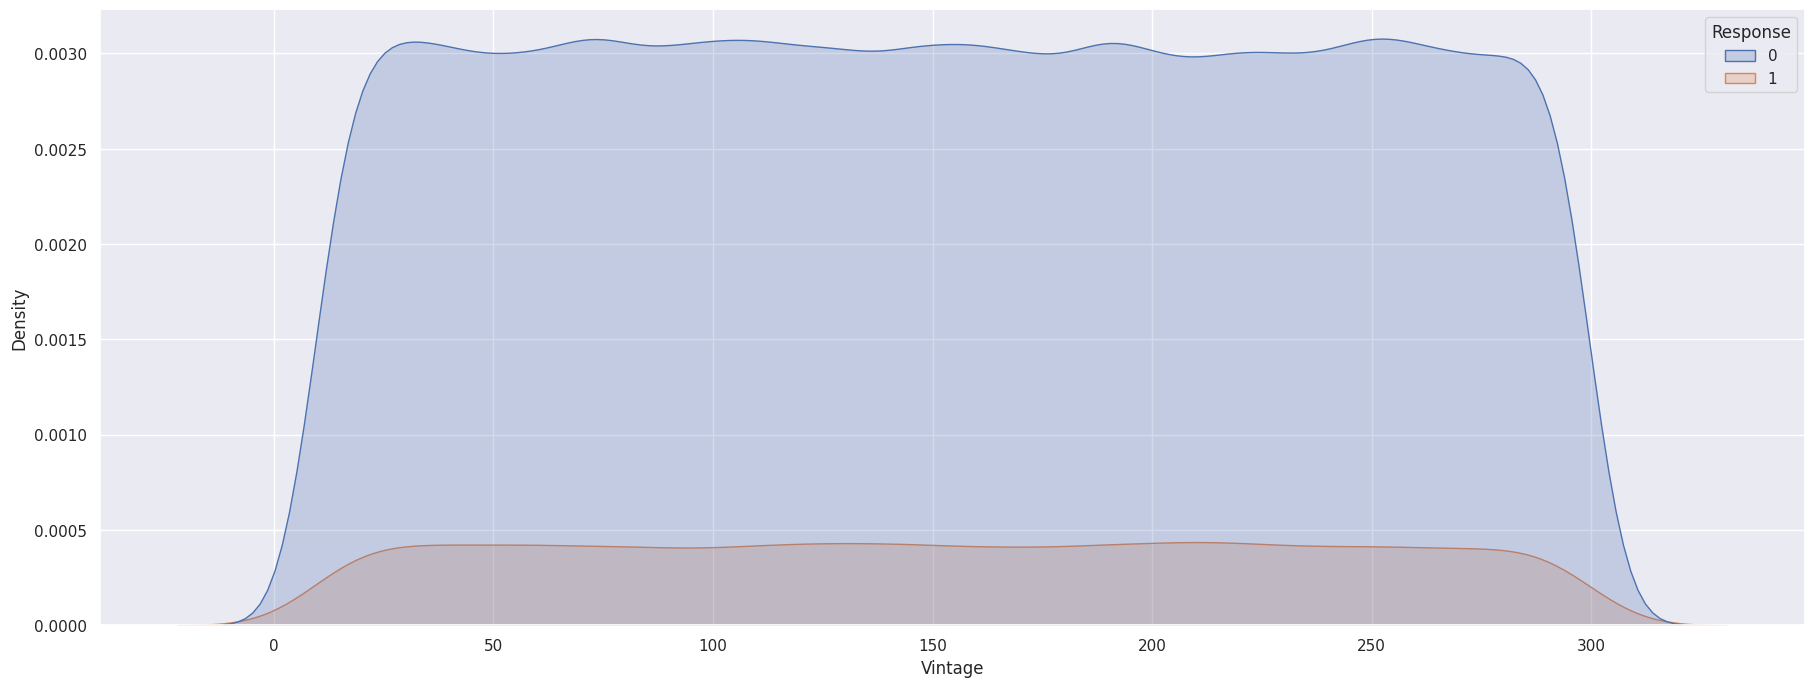

In [35]:
sns.kdeplot(data = df_1, x='Vintage', hue='Response', fill=True, label = 'Response')

**Conclusão:** Falso, o vintage possuí impacto algum sobre a decisão de adquirir ou não adquirir um seguro veicular

### H4. Clientes com ticket mais elevado, possuem maior propensão de compra

**Conclusão:** Falso, o interesse do cliente em comprar ou não comprar, não é influenciado pelo annual premium pago pelo cliente

In [36]:
print('**Clientes que adquiririam o Seguro**')
print(df_1[df_1.Response == 1].Annual_Premium.describe())

print('-'*45)
print('**Clientes NAO que adquiririam o Seguro**')

print(df_1[df_1.Response == 0].Annual_Premium.describe())

**Clientes que adquiririam o Seguro**
count     29699.000000
mean      31619.772551
std       18557.744433
min        2630.000000
25%       24943.000000
50%       33009.000000
75%       41283.500000
max      540165.000000
Name: Annual_Premium, dtype: float64
---------------------------------------------
**Clientes NAO que adquiririam o Seguro**
count    214210.000000
mean      30403.955964
std       17024.481880
min        2630.000000
25%       24331.000000
50%       31508.000000
75%       39117.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


<Axes: xlabel='Annual_Premium', ylabel='Density'>

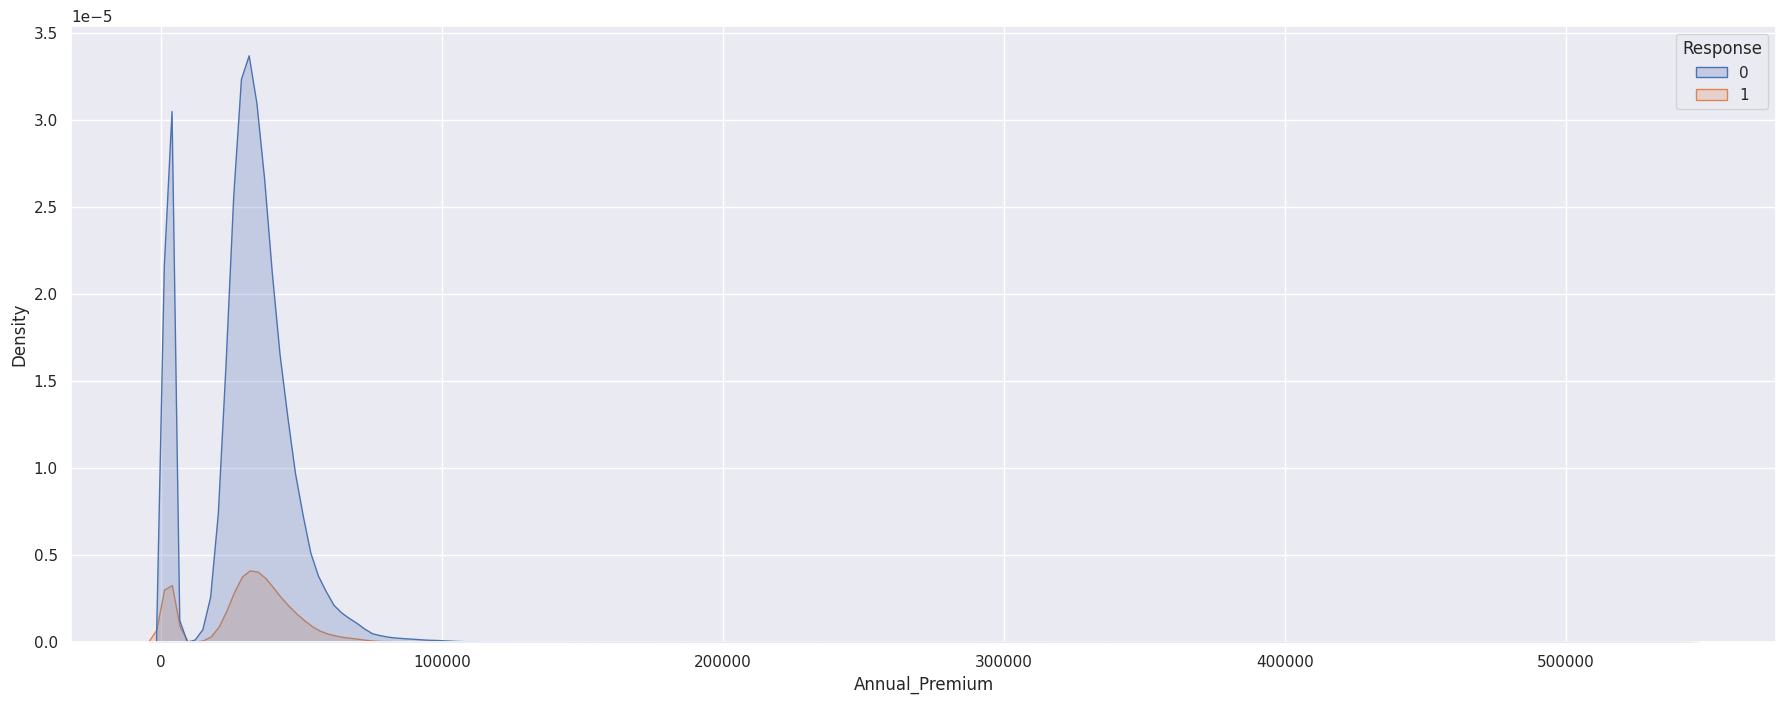

In [37]:
sns.kdeplot(data = df_1, x='Annual_Premium', hue='Response', fill=True, label = 'Response')

### H5 - Clientes com veículos mais novos possuem maior propensão de compra

**Conclusão:** Falsa, na realidade clientes com veiculos mais antigos, no geral, possuem uma maior tendencia a adquirir o seguro, que clientes com veículos mais novos

In [ ]:
df_1.Vehicle_Age.value_counts()
df_1.loc[:,'Vehicle_Age'] = df_1.loc[:,'Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})



df_vehicle_age = get_frequency_table(df_1, 'Vehicle_Age')
df_vehicle_age


,Vehicle_Age,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy
0,0,4574,100809,105383,0.043404,0.154012,0.470608
1,1,22106,106175,128281,0.172325,0.744335,0.495658
2,2,3019,7226,10245,0.294680,0.101653,0.033733


<Axes: xlabel='Vehicle_Age', ylabel='Propensity_to_buy'>

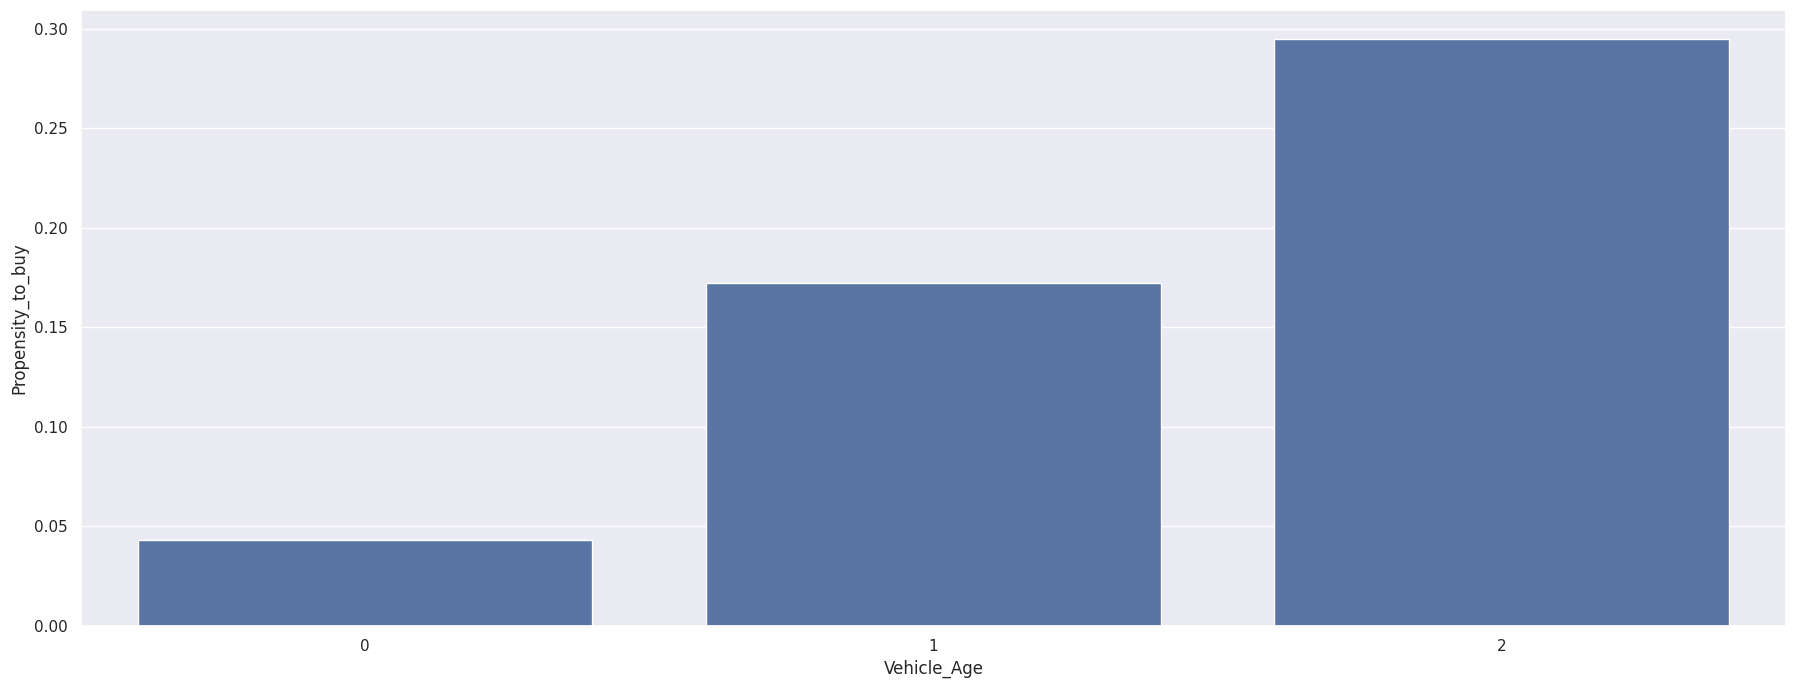

In [44]:
sns.barplot(data=df_vehicle_age, x='Vehicle_Age', y='Propensity_to_buy')

### H6 - Clientes com seguro veicular possuem menor propensão de compra

**Conclusão:** Verdadeira, clientes que já possuem seguro veicular, possuem uma propensão de compra muuito menor, em relação aos que não possuem. Praticamente todos os clientes que disseram comprar o seguro ofertado pela empresa, não possuem um seguro previo > (99%)

In [47]:
df_previously_insured = get_frequency_table(df_1, 'Previously_Insured')
df_previously_insured

,Previously_Insured,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy
0,0,29599,102546,132145,0.223989,0.996633,0.478717
1,1,100,111664,111764,0.000895,0.003367,0.521283


Text(0.5, 1.0, 'Propensão de compra x Previously_Insured')

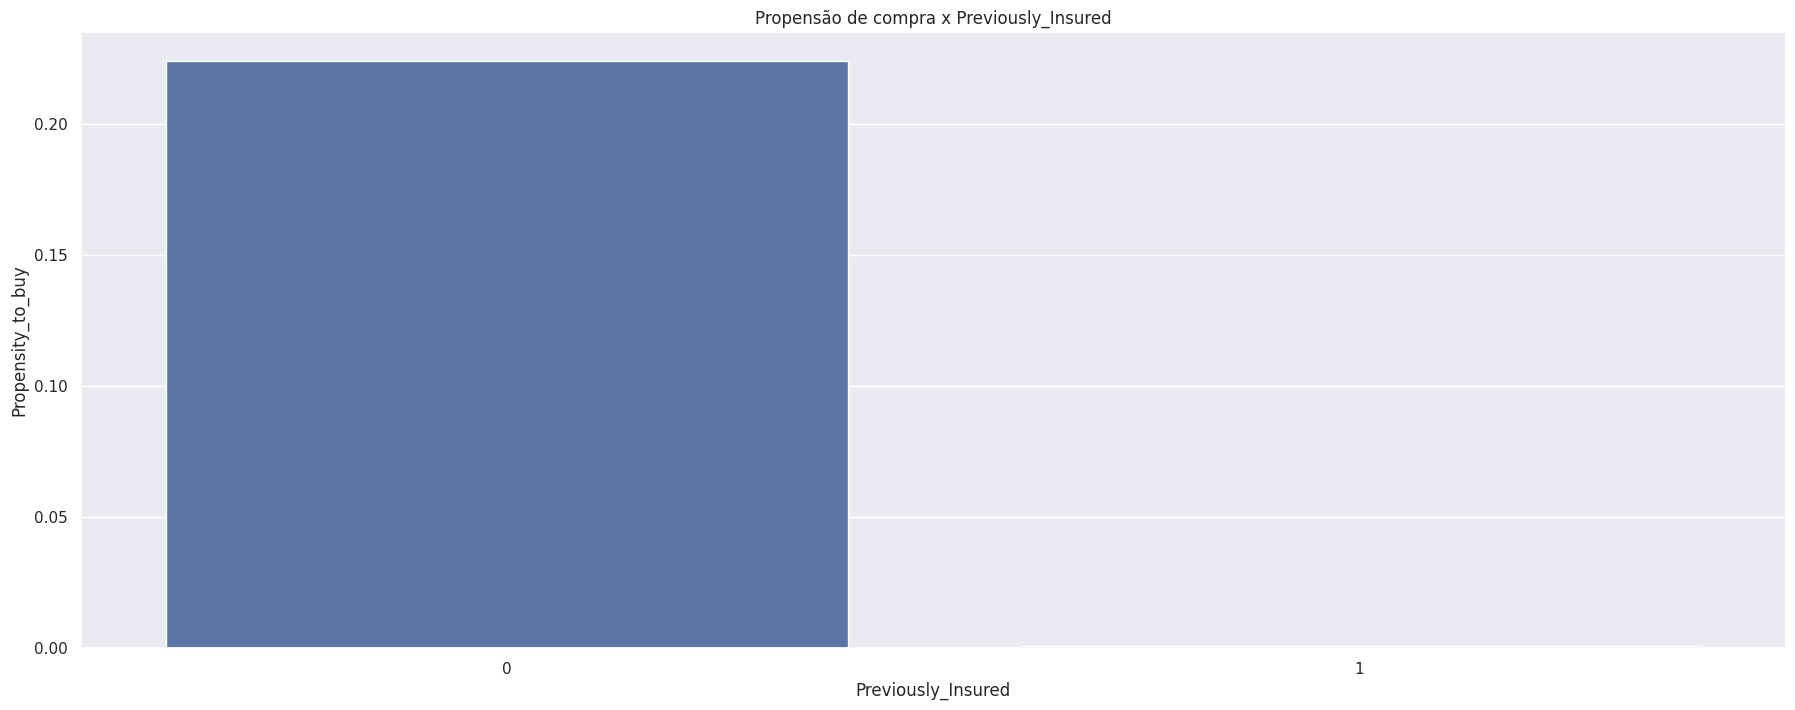

In [50]:
sns.barplot(data=df_previously_insured, x='Previously_Insured', y='Propensity_to_buy')
plt.title('Propensão de compra x Previously_Insured')

### H7. Existem regiões, onde os clientes possuem maior propensão de compra

**Conclusão:** Sim, ha regiões com maior propensão de compra, que outras, inclusive, a região mais interessate é a região com codigo 28, cujo 18% dos entrevistados comprariam o produto, além da região concentrar cerca de 28% dos entrevistados 

In [53]:
df_1.Region_Code.nunique()

53

In [57]:
df_region_code = get_frequency_table(df_1, 'Region_Code')
df_region_code.sort_values(by='Propensity_to_buy', ascending=False)

,Region_Code,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size
38,38.0,251,1007,1258,0.199523,0.008451,0.004701,0.005158
28,28.0,12693,55503,68196,0.186125,0.427388,0.259106,0.279596
19,19.0,165,846,1011,0.163205,0.005556,0.003949,0.004145
4,4.0,173,968,1141,0.151621,0.005825,0.004519,0.004678
51,51.0,17,96,113,0.150442,0.000572,0.000448,0.000463
23,23.0,187,1061,1248,0.149840,0.006297,0.004953,0.005117
24,24.0,225,1353,1578,0.142586,0.007576,0.006316,0.006470
7,7.0,283,1782,2065,0.137046,0.009529,0.008319,0.008466
52,52.0,24,162,186,0.129032,0.000808,0.000756,0.000763
18,18.0,423,2897,3320,0.127410,0.014243,0.013524,0.013612


Text(0.5, 1.0, 'Propensão de compra x Region_Code')

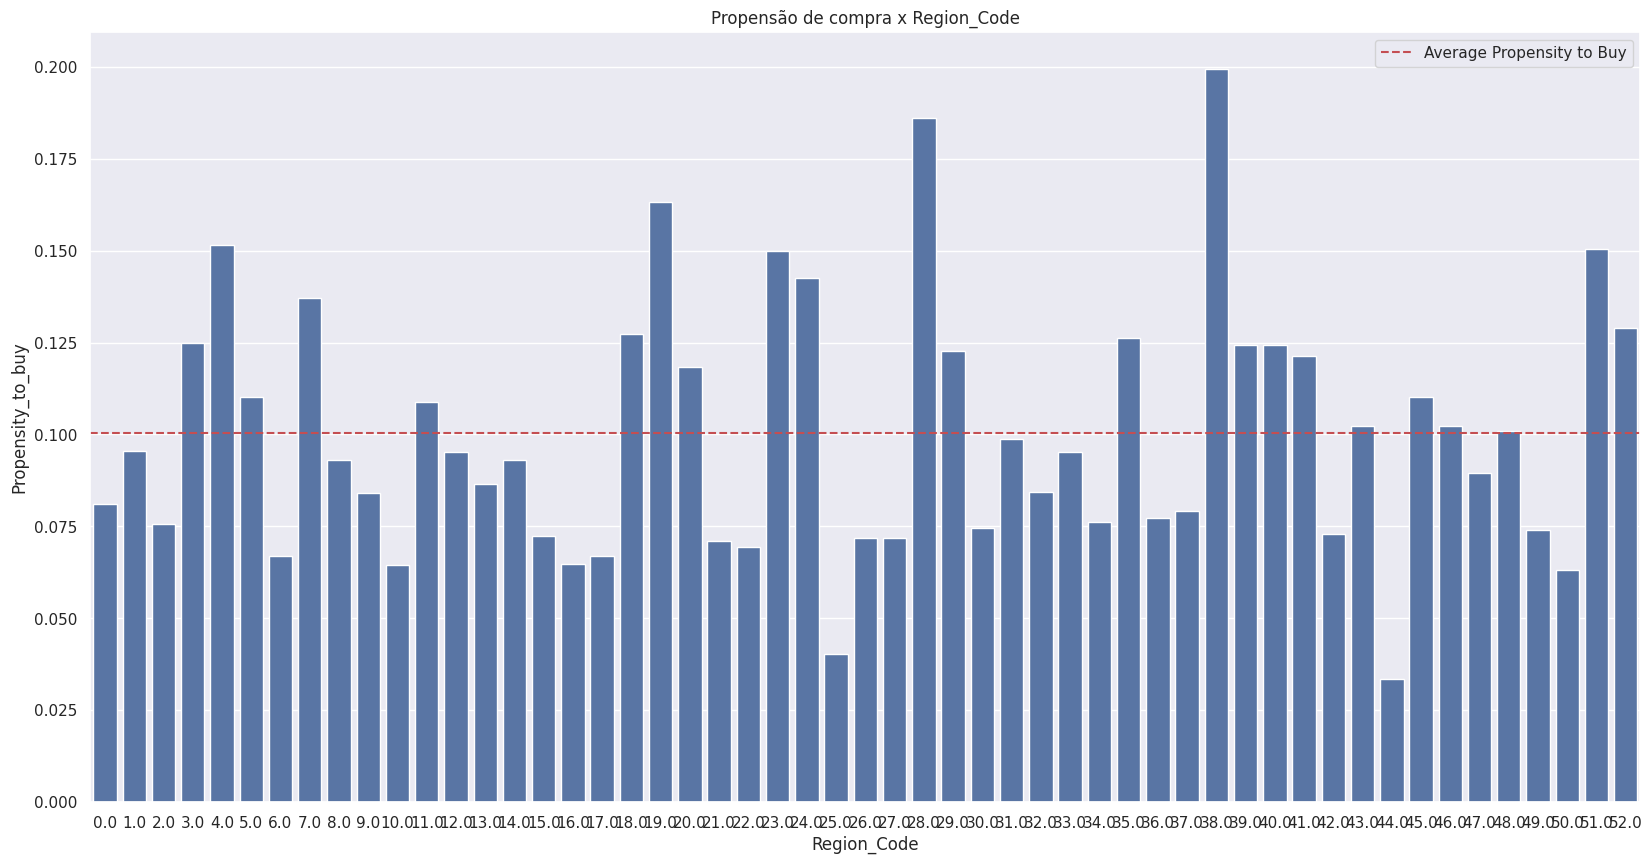

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
ax.axhline(y=df_region_code.Propensity_to_buy.mean(), color='r', linestyle='--', label='Average Propensity to Buy')
sns.barplot(data=df_region_code, x='Region_Code', y='Propensity_to_buy')
plt.title('Propensão de compra x Region_Code')

### H8. Clientes com veiculos que ja sofreram danos, possuem maior propensão a aquisição do seguro 

**Conclusão** Verdadeiro, clientes que ja tiveram algum tipo de dano veicular, possuem uma tendencia a aquisição de um seguro muito maior, que clientes que nunca tiveram (23% vs 0.5%)

In [61]:
df_vehicle_damage = get_frequency_table(df_1, 'Vehicle_Damage')
df_vehicle_damage.sort_values(by='Propensity_to_buy', ascending=False)


,Vehicle_Damage,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size
1,Yes,29074,94174,123248,0.235898,0.978956,0.439634,0.505303
0,No,625,120036,120661,0.005180,0.021044,0.560366,0.494697


### H9. Clientes com mais de 30 anos, são mais propensos a adquirir o seguro.


In [63]:
print_descriptive_stats(df_1, 'Age')

**Clientes que adquiririam o Seguro - Age statistics**
count    29699.000000
mean        43.512846
std         12.188968
min         20.000000
25%         35.000000
50%         43.000000
75%         51.000000
max         83.000000
Name: Age, dtype: float64
---------------------------------------------
**Clientes NAO que adquiririam o Seguro - Age statistics**
count    214210.000000
mean         38.169282
std          15.812357
min          20.000000
25%          24.000000
50%          34.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64




In [64]:
df_age = get_frequency_table(df_1, 'Age')
df_age.sort_values(by='Propensity_to_buy', ascending=False)

,Age,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size
18,38,832,2802,3634,0.228949,0.028014,0.013081,0.014899
15,35,714,2466,3180,0.224528,0.024041,0.011513,0.013038
16,36,731,2530,3261,0.224164,0.024614,0.011812,0.013370
27,47,1019,3616,4635,0.219849,0.034311,0.016882,0.019003
14,34,670,2437,3107,0.215642,0.022560,0.011377,0.012738
20,40,999,3645,4644,0.215116,0.033637,0.017017,0.019040
19,39,866,3190,4056,0.213511,0.029159,0.014893,0.016629
26,46,1083,3997,5080,0.213189,0.036466,0.018660,0.020827
25,45,1118,4127,5245,0.213155,0.037644,0.019267,0.021504
13,33,691,2553,3244,0.213009,0.023267,0.011919,0.013300


### H11. Clientes do sexo feminino, possuem maior propensão a aquisição de seguros veiculares
